# Why Post-Training Matters

**Understanding the gap between pre-trained and aligned models**

## The Pre-Training Gap

A pre-trained language model is impressive—it has learned grammar, facts, reasoning patterns, and even some common sense from billions of words of text. But there's a fundamental gap between "predicting the next word" and "being a helpful assistant."

**Pre-training teaches:** Given text, predict what comes next.

**Users want:** Given a question, provide a helpful answer.

## What Pre-Trained Models Actually Learn

Pre-training optimizes:

$$\mathcal{L}_{\text{pretrain}} = -\sum_{t} \log P(x_t | x_{<t})$$

This means the model learns to predict the **most likely** continuation, not the **most helpful** one.

**Example:** If trained on internet text, the model learns that after "How do I hack..." often comes tutorials on hacking, not refusals.

In [1]:
# Demonstration: Base model behavior vs. aligned model behavior

examples = [
    {
        "prompt": "Write a poem about",
        "base": "Write a poem about nature. The trees sway gently...",  # Continues the text
        "aligned": "I'd be happy to write a poem for you! What topic would you like?"  # Responds helpfully
    },
    {
        "prompt": "What is 2+2?",
        "base": "What is 2+2? What is 3+3? These basic math questions...",  # Continues pattern
        "aligned": "2 + 2 = 4"  # Answers directly
    },
    {
        "prompt": "Can you help me with my homework?",
        "base": "Can you help me with my homework? asked Sarah nervously...",  # Writes a story
        "aligned": "Of course! What subject is your homework in?"  # Offers assistance
    }
]

for ex in examples:
    print(f"Prompt: {ex['prompt']}")
    print(f"  Base model: {ex['base'][:60]}...")
    print(f"  Aligned model: {ex['aligned']}")
    print()

Prompt: Write a poem about
  Base model: Write a poem about nature. The trees sway gently......
  Aligned model: I'd be happy to write a poem for you! What topic would you like?

Prompt: What is 2+2?
  Base model: What is 2+2? What is 3+3? These basic math questions......
  Aligned model: 2 + 2 = 4

Prompt: Can you help me with my homework?
  Base model: Can you help me with my homework? asked Sarah nervously......
  Aligned model: Of course! What subject is your homework in?



## Three Problems Post-Training Solves

### 1. Format Problem

Pre-trained models don't know they should **respond** to questions rather than **continue** them.

**SFT teaches:** When you see a question, generate an answer.

### 2. Quality Problem  

Many valid completions exist, but humans prefer some over others.

**RLHF/DPO teaches:** Among valid responses, prefer ones humans rate highly.

### 3. Safety Problem

The internet contains harmful content. A model trained on it will happily generate harmful content.

**Alignment teaches:** Refuse harmful requests, be honest about limitations.

## The Alignment Tax

Post-training isn't free. There's often a tradeoff:

| Capability | Pre-training | Post-training | Net Effect |
|-----------|-------------|---------------|------------|
| Raw knowledge | +++++ | - | Slight decrease |
| Following instructions | + | +++++ | Large increase |
| Safety/Refusals | - | +++++ | Large increase |
| Helpfulness | ++ | ++++ | Moderate increase |

The "alignment tax" refers to the small decrease in raw capabilities that sometimes accompanies making models safer and more helpful. Modern techniques minimize this tradeoff.

## Evidence: InstructGPT Paper

OpenAI's InstructGPT paper (2022) showed dramatic results:

- **1.3B InstructGPT** outperformed **175B GPT-3** on human preference evaluations
- Users preferred InstructGPT outputs 85% of the time
- The model was more truthful and less toxic

**Key insight:** A small model with good post-training beats a large model without it.

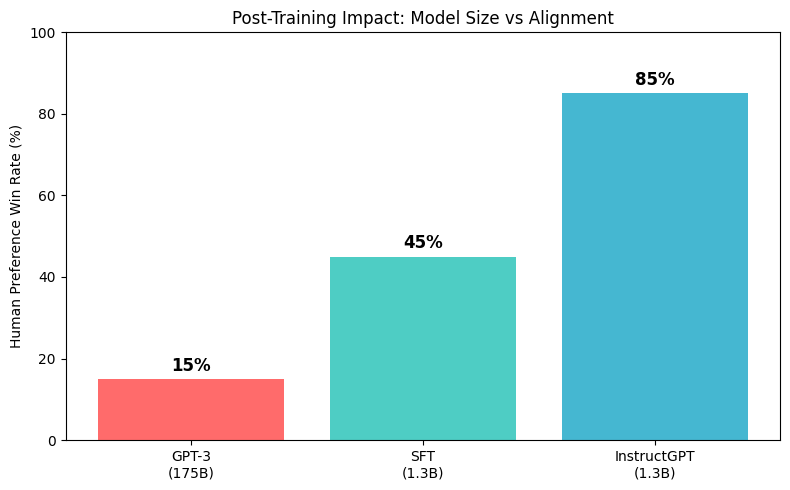

Key insight: A 1.3B parameter model with RLHF beats a 175B model without it!


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization of the InstructGPT results
models = ['GPT-3\n(175B)', 'SFT\n(1.3B)', 'InstructGPT\n(1.3B)']
human_preference = [15, 45, 85]  # Approximate win rates vs GPT-3

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(models, human_preference, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
ax.set_ylabel('Human Preference Win Rate (%)')
ax.set_title('Post-Training Impact: Model Size vs Alignment')
ax.set_ylim(0, 100)

for bar, val in zip(bars, human_preference):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{val}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Key insight: A 1.3B parameter model with RLHF beats a 175B model without it!")

## What We'll Build

In this tutorial series, we'll implement:

1. **SFT** — Supervised fine-tuning with instruction formatting and loss masking
2. **Reward Models** — Train models to predict human preferences
3. **RLHF** — Full PPO training loop with KL penalty
4. **DPO** — Simpler alternative that skips the reward model

By the end, you'll understand exactly how models like GPT-4 and Claude are trained after pre-training.

## Next Steps

Now that we understand why post-training matters, let's look at the project overview and then dive into Supervised Fine-Tuning (SFT).